## Unspoiled - Data Labeling
#### Ben Cobb

Spring 2024

## Imports and Libraries

In [1]:
import cv2 as cv
import numpy as np
import os
import random
from PIL import Image
from matplotlib import pyplot as plt

# Global Variables

In [2]:
# This is the overall path, change this to wherever the project is saved on your system
path = "/Users/molte/OneDrive/Desktop/UAFS/~Spring 2024/Capstone/Unspoiled/"

classes = ["milk", "eggcarton", "creamer", "apple", "banana", "pear", "coughdrops", "cheezit", "soda"]
'''
classIDs:
0 = "milk"
1 = "eggcarton"
2 = "creamer"
3 = "apple"
4 = "banana"
5 = "pear"
6 = "coughdrops"
7 = "cheezit"
8 = "soda"
'''

########################################################
# CHANGE THIS BASED ON WHAT ITEM CLASS YOU'RE LABELING #
########################################################
classID = 4

item = classes[classID] + "/"

# loadpath = path + "images/" + item
loadpath = path + "images/test/" + item

savepath = path + "processed/" + item
labelpath = path + "labels/" + item
boxpath = path + "boxed/" + item

##################################################
# CHANGE THIS BASED ON CAMERA SET UP             #
# POINTS SHOULD BE THE PIXEL COORDS OF THE TABLE #
##################################################
offsetBars = 70   # this is to account for the black bars that are added to make the image square
offsetX = 10      # value to expand the visible cols by
offsetY = 13      # value to expand the visible rows by

# TL, TR, BR, BL
'''
# Old data sets
tl = (31, 33)
tr = (291, 14)
br = (314, 118)
bl = (18, 133)
'''

tl = (round(130 / 4), round(161 / 4))
tr = (round(1122 / 4), round(144 / 4))
br = (round(1166 / 4), round(471 / 4))
bl = (round(98 / 4), round(495 / 4))

points = np.array([(tl[0]-offsetX, tl[1]-offsetY+offsetBars), (tr[0]+offsetX, tr[1]-offsetY+offsetBars), (br[0]+offsetX, br[1]+offsetY+offsetBars), (bl[0]-offsetX, bl[1]+offsetY+offsetBars)]) 

########################################
# CHANGE THIS ONLY WHEN COLORS ARE OFF #
########################################
# RGB Color limits indexed by classID
lowers = np.array([[170, 170, 190], [70, 160, 200], [235, 50, 100], [220, 40, 40], [220, 210, 130], [230, 210, 130], [225, 150, 140], [235, 50, 100], [0, 120, 85]])
uppers = np.array([[255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 190, 202], [255, 255, 255], [255, 255, 255], [255, 255, 255], [255, 255, 255], [130, 210, 200]])
areas = np.array([[300, 1000], [500, 2600], [100, 1500], [60, 400], [35, 1000], [50, 170], [200, 1500], [400, 1500], [600, 2500]]) 
    
####################################################
# CHANGE THIS BASED ON UNIFORMITY OF ITEM COLORING #
####################################################
uniform = (False, True, False, True, True, True, True, False, False)

cmap = "gray"

# Methods

### ...to find the items...

In [3]:
# Reshapes and resizes the image, given an image path
def resize(imgPath):
    
    loadImg = loadpath + imgPath
    img = cv.imread(loadImg)  # Reads in the image from the load path
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Converts it from OpenCV's BGR to normal RGB
    
    yrows, xcols, dim = img.shape
    
    # Determine the size of the black background
    maxDim = max(yrows, xcols)
    black = np.zeros((maxDim, maxDim, 3), dtype=img.dtype)
    
    # Calculate coordinates to place the original image centered on the black background
    offsetY = (maxDim - yrows) // 2
    offsetX = (maxDim - xcols) // 2
    
    # Place original image on black background centered
    black[offsetY:offsetY+yrows, offsetX:offsetX+xcols] = img
    
    # Use the centered image for further processing
    img = black
    
    # Resizes the image
    resized = cv.resize(img, (int(maxDim / 4), int(maxDim / 4)))
    
    return resized

In [4]:
# Removes the background noise (assuming we know the position)
def removeSurroundings(resized):

    # Creates a mask with the same size as the image
    mask = np.zeros(resized.shape, dtype=np.uint8)

    # This fills our mask (in a rectangle between the two points), with the RGB color value
    cv.fillConvexPoly(mask, points, (255, 255, 255))

    # Make everything outside the rectangle black
    # Bitwise_And applies our mask to the image
    tableOnly = cv.bitwise_and(resized, mask)
    return tableOnly

In [27]:
#### Finds an item and returns bounding box info -- (x_center, y_center, width, height)
def findItem(resized, img):

    # Sets lower and upper color bounds
    lower = lowers[classID]
    upper = uppers[classID]
    
    # Used for TESTING lower/upper bounds
#    lower = np.array([235, 50, 100])
#    upper = np.array([255, 255, 255])
    
    # Gets the usual areaRange of an item
    areaRange = areas[classID]
 #   areaRange = (100, 1500)

    # Creates a mask to threshold the chosen color
    # This means we can select anything this color and either remove it or remove everything but it
    mask = cv.inRange(img, lower, upper)
    
    ##############################################
    # USE THIS IF ITEM IS MOSTLY UNIFORM COLORING
    if uniform[classID]:        
        mask = cv.bitwise_not(mask)
        
    # Combines multiple color masks!
    else:

        # Special for Milk Jug
        if classID == 0:
            
            # Isolates blues (cap)
            lowerBlueC = np.array([0, 60, 190])
            upperBlueC = np.array([110, 180, 255])
    
            # Isolates blues (label)
            lowerBlueL = np.array([50, 70, 130])
            upperBlueL = np.array([110, 170, 180])
            
            # Makes the masks
            maskBlueC = cv.inRange(img, lowerBlueC, upperBlueC)
            maskBlueL = cv.inRange(img, lowerBlueL, upperBlueL)
            
            # Combines the masks
            maskBoth = cv.bitwise_or(maskBlueC, maskBlueL)

            # Isolates dark blues (label)
            lowerDarkBlueL = np.array([0, 20, 50])
            upperDarkBlueL = np.array([30, 50, 140])
            
            # Isolates label grays
            lowerGray = np.array([150, 170, 200])
            upperGray = np.array([190, 220, 245])
            
            # Makes more masks
            maskDarkBlueL = cv.inRange(img, lowerDarkBlueL, upperDarkBlueL)
            maskGray = cv.inRange(img, lowerGray, upperGray)
            maskBoth2 = cv.bitwise_or(maskDarkBlueL, maskGray)
            
            # Combines the masks
            maskAll = cv.bitwise_or(maskBoth, maskBoth2)
            
            # Combines the combined mask with the main mask
            mask = cv.bitwise_or(mask, maskAll)

        # Special for Creamer
        elif classID == 2:

            # Converts the image to HSV
            hsvimg = cv.cvtColor(img, cv.COLOR_RGB2HSV)  # Converts it from OpenCV's BGR to normal RGB

            # Isolates some particular HSV bounds
            lowerHue1 = np.array([90, 15, 125])
            upperHue1 = np.array([180, 255, 255])

            lowerHue2 = np.array([15, 75, 190])
            upperHue2 = np.array([25, 120, 227]) # change third
            
            # Makes HSV masks
            maskHue1 = cv.inRange(hsvimg, lowerHue1, upperHue1)
            maskHue2 = cv.inRange(hsvimg, lowerHue2, upperHue2)
            
            maskHues = cv.bitwise_or(maskHue1, maskHue2)
            
            lowerHue3 = np.array([0, 0, 250])
            upperHue3 = np.array([100, 50, 255])
            maskHue3 = cv.inRange(hsvimg, lowerHue3, upperHue3)
            
            maskHues = cv.bitwise_or(maskHues, maskHue3)
            
            # Isolates bright whites
            lowerWhite = np.array([220, 210, 150])
            upperWhite = np.array([255, 255, 255])

            # Isolates hues where green
            lowerGreen = np.array([35, 35, 150])
            upperGreen = np.array([100, 90, 205]) 
            
            # Makes the color mask
            maskWhite = cv.inRange(img, lowerWhite, upperWhite)
            maskGreen = cv.inRange(hsvimg, lowerGreen, upperGreen)
            maskColors = cv.bitwise_or(maskWhite, maskGreen)
                        
            # Combines the masks
            maskBoth = cv.bitwise_or(maskHues, maskColors)
            
            # Combines the combined mask with the main mask
            mask = cv.bitwise_or(mask, maskBoth)
            
        # Special for Cheez-its Box
        elif classID == 7:

            # Converts the image to HSV
            hsvimg = cv.cvtColor(img, cv.COLOR_RGB2HSV)  # Converts it from OpenCV's BGR to normal RGB

            # Isolates some particular HSV bounds
            lowerHue1 = np.array([170, 50, 125])
            upperHue1 = np.array([181, 155, 255])

            lowerHue2 = np.array([0, 100, 70])
            upperHue2 = np.array([20, 155, 255])
            
            # Makes HSV masks
            maskHue1 = cv.inRange(hsvimg, lowerHue1, upperHue1)
            maskHue2 = cv.inRange(hsvimg, lowerHue2, upperHue2)
            
            # Combines the masks
            maskHues = cv.bitwise_or(maskHue1, maskHue2)
            
            # Combines the combined mask with the main mask
            mask = cv.bitwise_or(mask, maskHues)

        # Special for Sprite Soda Box
        elif classID == 8:

            # Isolates bright whites
            lowerWhite = np.array([0, 230, 200])
            upperWhite = np.array([255, 255, 255])

            # Isolates side whites
            lowerSide = np.array([130, 180, 180])
            upperSide = np.array([200, 255, 255])
            
            # Makes the masks
            maskWhite = cv.inRange(img, lowerWhite, upperWhite)
            maskSide = cv.inRange(img, lowerSide, upperSide)
            
            maskBoth = cv.bitwise_or(maskWhite, maskSide)
            
            # Combines the combined mask with the main mask
            mask = cv.bitwise_or(mask, maskBoth)
            
    ##############################################
    
    # Finds contours of the area
    # This is a whole thing I'll have to explain with pictures
    # But it basically tries to find the edges of everything in the picture
    ###################
    # CONTOUR LOOPING #
    ###################
    contours, heirarchy = cv.findContours(mask, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    justItems = resized.copy()
    
    boxes = []
    
    # Loops through the contours that cv.findContours found
    for cntr in contours:

        # These numbers will change based on item and situation
        # But they're basically to remove most items that aren't roughly the
        # size and shape we expect.

        # This is here to account for some wobbliness in numbers since being exact would be hard
        epsilon = 0.1 * cv.arcLength(cntr, True)
        approx = cv.approxPolyDP(cntr, epsilon, True)
        
        # This is the area within a particular contour
        area = cv.contourArea(cntr)

        # It then draws lines on the picture to outline the item
        if area > areaRange[0] and area < areaRange[1]:
                        
            x, y, w, h = cv.boundingRect(cntr)

            # Bounding box coords
            topleft = (x, y)
            bottomright = (x + w, y + h)
            
            center = (x + w/2, y + h/2)

            # Formatting the data to YOLO specifications
            imgWidth = img.shape[1]
            imgHeight = img.shape[0]
            xRel = center[0] / imgWidth
            yRel = center[1] / imgHeight
            wRel = w / imgWidth
            hRel = h / imgHeight

            if h > 10 and w > 10: # Can remove this "if" if needed (added for cough drops)
                
                allAreas.append(area)    # just used to help calibrate values in testing
                
                # Format: (classID, x_center, y_center, width, height)
                boxInfo = [classID, xRel, yRel, wRel, hRel] 
                boxes.append(boxInfo)
                
                # Draws bounding rectangle
                cv.rectangle(justItems, topleft, bottomright, (50, 205, 50), 2) 
 
    #####################################################################
    # This is just a test display to verify the mask and bounding boxes #
    showImages(resized, mask)
    showImages(resized, justItems)

    return boxes

### ...to manipulate images...

In [6]:
# Blurs the image (if we need a lesser blur, we can change the (x, x) value to another, smaller odd number
def blurImage(image):

    blurred = cv.GaussianBlur(image, (15,15), 0)

    return blurred

In [7]:
# Jitters the image by brightness, saturation, and contrast
def colorJitter(image):
    
    hsv = cv.cvtColor(image, cv.COLOR_RGB2HSV)
    hue, sat, val = cv.split(hsv)
    
    # Random values to help alter the images
    randVal = np.random.choice(np.array([-55, -50, -45, -40, -35, -30, 30, 35, 40, 45, 50, 55]))
    randSat = np.random.choice(np.array([-55, -50, -45, -40, -35, -30, 30, 35, 40, 45, 50, 55]))

    # Ensuring that the values stay within range
    if randVal >= 0:
        lim = 255 - randVal
        val[val > lim] = 255
        val[val <= lim] += randVal
    else:
        lim = np.absolute(randVal)
        val[val < lim] = 0
        val[val >= lim] -= np.absolute(randVal)
    
    if randSat >= 0:
        lim = 255 - randSat
        sat[sat > lim] = 255
        sat[sat <= lim] += randSat
    else:
        lim = np.absolute(randSat)
        sat[sat < lim] = 0
        sat[sat >= lim] -= np.absolute(randSat)
    
    # Merging the split HSV into a single image again
    merged = cv.merge((hue, sat, val))
    image = cv.cvtColor(merged, cv.COLOR_HSV2RGB)
        
    # Changes Contrast
    brightness = 10
    contrast = random.randint(40, 100)

    temp = np.int16(image)
    temp = temp * (contrast/127+1) - contrast + brightness
    temp = np.clip(temp, 0, 255)
    image = np.uint8(temp)
        
    return image

In [8]:
# Flips the images either horizontally (dir = 0) or vertically (dir = 1)
def flipImages(images, dir):

    flipped = []
    for img in images:
        flippedImg = cv.flip(img, dir)
        flipped.append(flippedImg)
    
    return flipped

In [9]:
# Flips the box coordinates
def flipBoxes(boxes):
    
    boxesFlippedHoriz = []
    boxesFlippedVert = []
    boxesFlippedBoth = []

    for box in boxes:
        boxHoriz = box.copy()
        boxHoriz[2] = 1 - box[2]
        
        boxVert = box.copy()
        boxVert[1] = 1 - box[1]
        
        boxBoth = boxHoriz.copy()
        boxBoth[1] = 1 - box[1]
    
        boxesFlippedHoriz.append(boxHoriz)
        boxesFlippedVert.append(boxVert)
        boxesFlippedBoth.append(boxBoth)

    return (boxes, boxesFlippedHoriz, boxesFlippedVert, boxesFlippedBoth)

In [10]:
# Manipulates and multiplies the images
def multiplyImages(resized):

    # Setting up the initial image
    image = resized.copy()
    
    # Processing it three ways
    blurred = blurImage(image)
    jittered1 = colorJitter(image)
    jittered2 = colorJitter(image)
    
    # Makes images into a list
    imagesMult = []
    imagesMult.append(image)
    imagesMult.append(blurred)
    imagesMult.append(jittered1)
    imagesMult.append(jittered2)
    
    # Flipping the images in three ways
    flippedHoriz = flipImages(imagesMult, 0)
    flippedVert = flipImages(imagesMult, 1)
    flippedBoth = flipImages(flippedHoriz, 1)
    
    # Appending all of the images into one List
    imagesMult.extend(flippedHoriz)
    imagesMult.extend(flippedVert)
    imagesMult.extend(flippedBoth)

    return imagesMult

### ...to save what was processed...

In [11]:
# Creates the necessary folders
def createFolders():
    
    if not os.path.exists(loadpath):
        os.makedirs(loadpath)
    if not os.path.exists(savepath):
        os.makedirs(savepath)
    if not os.path.exists(labelpath):
        os.makedirs(labelpath)
    if not os.path.exists(boxpath):
        os.makedirs(boxpath)

In [12]:
# Writes box info to a .txt file
def writeBoxCoords(boxes, txtpath):

    label = open(txtpath, "w")
    for line in boxes:
    
        # Format: (classID, x_center, y_center, width, height)
        out = f"{line[0]} {line[1]:.6f} {line[2]:.6f} {line[3]:.6f} {line[4]:.6f}" 
        
        label.write(out + "\n")

    label.close()

In [13]:
# Saves the altered images and writes their bounding box coords
def saveAndWrite(images, allBoxes, imgPath):  
    imgName = imgPath[:-4]
    writeName = imgName + ".txt"
    
    count = 0
    boxCount = 0
    for img in images:

        # Setting up consistent filenames
        newName = imgName + "-" + str(count)
        newImgName = newName + ".png"
        newWriteName = newName + ".txt"
        
        imgTest = img.copy()
        boxes = allBoxes[boxCount]
        
        dim = imgTest.shape[0]
        ##############################
        # Calculates the actual pixels
        for box in boxes:
            
            x = box[1] * dim
            y = box[2] * dim
            w = box[3] * dim
            h = box[4] * dim
            
            topleft = (int(x - w/2), int(y - h/2))
            bottomright = (int(x + w/2), int(y + h/2))
    
            # Draws bounding rectangle
            cv.rectangle(imgTest, topleft, bottomright, (50, 205, 50), 2)         

        ##############################
                
        imgBGR = cv.cvtColor(img, cv.COLOR_RGB2BGR)  # Converts it from OpenCV's BGR to normal RGB
        imgBGRTest = cv.cvtColor(imgTest, cv.COLOR_RGB2BGR)  # Converts it from OpenCV's BGR to normal RGB
        
        cv.imwrite(savepath + newImgName, imgBGR)
        if count == 0:
            cv.imwrite(boxpath + newImgName, imgBGRTest)

        writeBoxCoords(allBoxes[boxCount], labelpath + newWriteName)
        
        count += 1
    
        if count % 4 == 0:
            boxCount += 1

    return count

### ...to display images...

In [14]:
# Displays two images next to each other
def showImages(imgBefore, imgAfter):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    axes[0].set_title("Before")
    axes[1].set_title("After")
    
    axes[0].imshow(imgBefore, cmap, vmin=0, vmax=255)
    axes[1].imshow(imgAfter, cmap, vmin=0, vmax=255)

In [15]:
# Displays two images next to each other
def showImages(imgBefore, imgAfter):
    
    fig, axes = plt.subplots(1, 2, figsize=(10, 10))
    
    axes[0].axis('off')
    axes[1].axis('off')
    
    axes[0].set_title("Before")
    axes[1].set_title("After")
    
    axes[0].imshow(imgBefore, cmap, vmin=0, vmax=255)
    axes[1].imshow(imgAfter, cmap, vmin=0, vmax=255)

In [16]:
# Displays two images next to each other
def showManipulatedImages(images):
    
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))
            
    axes[0][0].set_title("Original")
    axes[0][1].set_title("Blurred")
    axes[0][2].set_title("Jittered 1")
    axes[0][3].set_title("Jittered 2")

    axes[1][0].set_title("Flipped")
    axes[1][1].set_title("Blurred")
    axes[1][2].set_title("Jittered 1")
    axes[1][3].set_title("Jittered 2")

    axes[2][0].set_title("Flipped")
    axes[2][1].set_title("Blurred")
    axes[2][2].set_title("Jittered 1")
    axes[2][3].set_title("Jittered 2")

    axes[3][0].set_title("Flipped")
    axes[3][1].set_title("Blurred")
    axes[3][2].set_title("Jittered 1")
    axes[3][3].set_title("Jittered 2")

    count = 0
    for i in range(4):
        for j in range(4):
            axes[i][j].axis('off')
            axes[i][j].imshow(images[count], cmap, vmin=0, vmax=255)
            count += 1
                
    plt.tight_layout()

In [17]:
# Test displays bounding boxes on new images
def testBoxes(images, allBoxes):
    
    # Testing the bounding boxes on the new images
    imgTests = []
    
    count = 0
    boxCount = 0
    for img in images:
    
        imgTest = img.copy()
        boxes = allBoxes[boxCount]
    
        dim = imgTest.shape[0]
    
        ##############################
        # Calculates the actual pixels
        for box in boxes:
            
            x = box[1] * dim
            y = box[2] * dim
            w = box[3] * dim
            h = box[4] * dim
            
            topleft = (int(x - w/2), int(y - h/2))
            bottomright = (int(x + w/2), int(y + h/2))
    
            # Draws bounding rectangle
            cv.rectangle(imgTest, topleft, bottomright, (50, 205, 50), 2)         
    
        imgTests.append(imgTest)
        ##############################
        
        count += 1
        if count % 4 == 0:
            boxCount += 1

    return imgTests

### ...to do the entire process!

In [18]:
# Takes an image through the full process
def processingImage(imgPath):
    
    # Resizing and blurring the original image
    resized = resize(imgPath)
    blur = cv.GaussianBlur(resized, (5,5), 0) # This makes it easier for the next steps to work
    
    # Removes BG
    justTable = removeSurroundings(blur)
 #   showImages(resized, justTable)  # Used for testing, to make sure the table is being cropped correctly
    
    # Gets bounding box coords
    boxes = findItem(resized, justTable)

    ###############################
    # NOW, THE IMAGE MANIPULATION #
    ###############################
    # Flips the boxes for output
    allBoxes = flipBoxes(boxes)
    
    # Manipulates and multiplies the images
    imagesMult = multiplyImages(resized)

    # Saves the altered images and writes their bounding box coords
    
    # Create the folder (including any missing parent directories)
    count = saveAndWrite(imagesMult, allBoxes, imgPath)

    # Test displays bounding boxes on new images
    imgTests = testBoxes(imagesMult, allBoxes)
 #  showManipulatedImages(imgTests)   # Used for testing, to see all produced images from a single image

# Image Labeling

In [19]:
# Preparations go here
# Whether or not we need them?
# ¯\_(ツ)_/¯

1 images processed... banana40069.png
Done!


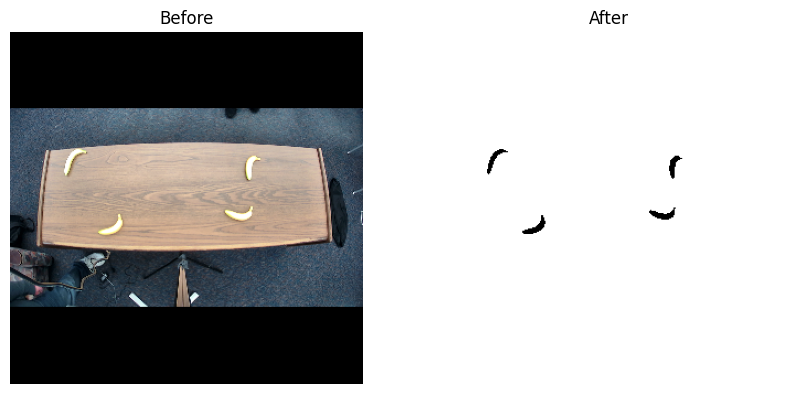

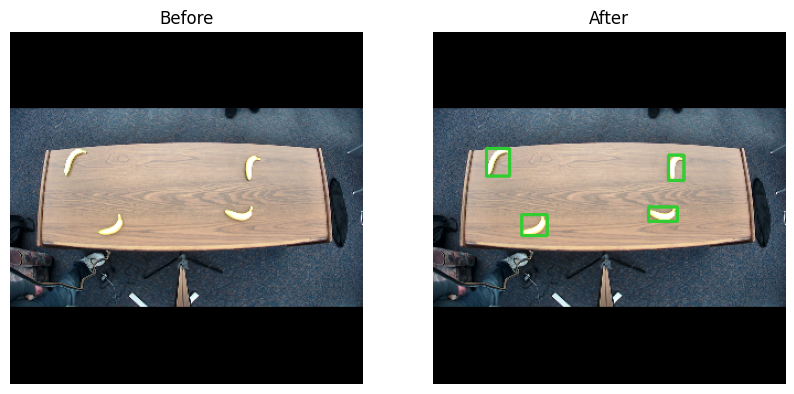

In [28]:
# Iterates through all files in the directory
count = 0
allAreas = []

createFolders()

for filename in os.listdir(loadpath):
    if filename.endswith('.png'):

        processingImage(filename)
        count += 1

        print(count, "images processed...", filename)

print("Done!")

In [ ]:
# This is to get the range of areas to properly bound it in item location
print("Areas:")
print(allAreas)

print("Min/Max Areas:")
print(min(allAreas), "--", max(allAreas))

print("Len:", len(allAreas))

print("Sorted:")
allAreas.sort()
print(allAreas)

# Testing Images

In [ ]:
'''
imgPath = "filename.png"
allAreas = []

createFolders()
processingImage(imgPath)
'''

In [ ]:
# Making color value histograms

# Load a small image
testpath = "/Users/molte/OneDrive/Desktop/UAFS/~Spring 2024/Capstone/imgtest.png"
img = cv.imread(testpath)

# Convert BGR to HSV
hsvimg = cv.cvtColor(img, cv.COLOR_BGR2HSV)

# Split HSV image into its components
h, s, v = cv.split(hsvimg)

# Plot the H, S, and V components
plt.figure(figsize=(10, 4))

plt.subplot(1, 3, 1)
plt.imshow(h, cmap='hsv')
plt.title('Hue (H)')
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(s, cmap)
plt.title('Saturation (S)')
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(v, cmap)
plt.title('Value (V)')
plt.colorbar()

plt.tight_layout()
plt.show()

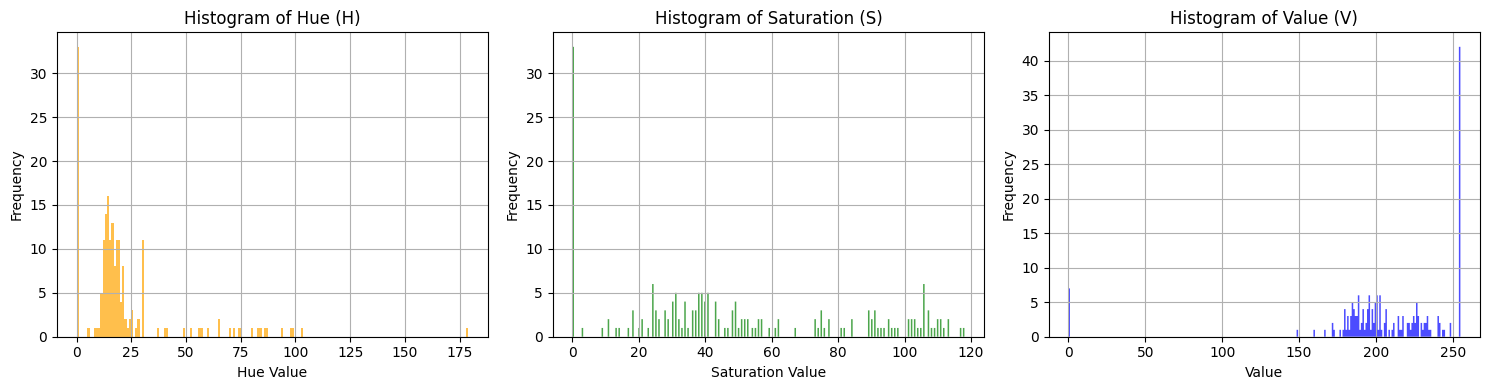

In [145]:
# Plot histograms of the hue, saturation, and value components
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.hist(h.ravel(), bins=180, color='orange', alpha=0.7, histtype='stepfilled')
plt.title('Histogram of Hue (H)')
plt.xlabel('Hue Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 3, 2)
plt.hist(s.ravel(), bins=256, color='green', alpha=0.7, histtype='stepfilled')
plt.title('Histogram of Saturation (S)')
plt.xlabel('Saturation Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.subplot(1, 3, 3)
plt.hist(v.ravel(), bins=256, color='blue', alpha=0.7, histtype='stepfilled')
plt.title('Histogram of Value (V)')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()